# DATA

$$ MSE = ∑ (y_{actual} - βX)^2 $$


$$\partial\beta = -\frac{2}{n}\Sigma X^T(y - \beta X)$$



$$\partial\beta = -\frac{2}{n}\Sigma X^T(y - \beta X) + \alpha \Sigma (abs(\beta))$$

$$\partial\beta = -\frac{2}{n}\Sigma X^T(y - \beta X) + \alpha * {sign} (\beta)$$


# Data Processing Using Tensorflow

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

data_filename = "data/mapped_dataset.csv"
tokenizer_path = "config/tokenizer_config.json"
max_tokens_file = "config/max_input"
data = pd.read_csv(data_filename)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['X'])
X = tokenizer.texts_to_sequences(data['X'])
X = pad_sequences(X)


df = pd.DataFrame()
df['mapping'] = data['mapping'].astype(str).apply(lambda x: [int(i) for i in x.split(',')])


max_length = max(df['mapping'].apply(len))
df['mapping'] = df['mapping'].apply(lambda x: x + [0] * (max_length - len(x)) if len(x) < max_length else x[:max_length])


Y = np.array(df['mapping'].tolist())

with open(max_tokens_file, "w") as file:
    file.write(str(max_tokens))



tokenizer_config = tokenizer.to_json()

with open(tokenizer_path, 'w') as json_file:
    json_file.write(tokenizer_config)


# Data Processing Using gensim

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import Word2Vec
import json
import nltk
nltk.download('punkt')
from matplotlib import pyplot as plt
import numpy as np


data_filename = "data/mapped_dataset.csv"
word_index_file = "config/word_to_index.json"
classes_file = "config/classes.txt"
max_tokens_file = "config/max_input"
data = pd.read_csv(data_filename)


tokenized_data = [word_tokenize(text.lower()) for text in data["X"]]
word2vec_model = Word2Vec(tokenized_data, vector_size=100, window=5, min_count=1, sg=1)

word_to_index = {word: word2vec_model.wv.key_to_index[word] for word in word2vec_model.wv.index_to_key}

with open(word_index_file, 'w') as json_file:
    json.dump(word_to_index, json_file)

data["X_tokenized"] = data["X"].apply(lambda text: [word_to_index[word] for word in word_tokenize(text.lower())])

X_tokenized = pd.DataFrame({'X_tokenized': data['X_tokenized']})
X_tokenized['X_tokenized'] = X_tokenized['X_tokenized'].apply(lambda x: ",".join(map(str, x)))


max_tokens = max(X_tokenized['X_tokenized'].apply(lambda x: len(x.split(','))))


with open(max_tokens_file, "w") as file:
    file.write(str(max_tokens))

column_names = [f'Token_{i}' for i in range(1, max_tokens + 1)]
X_tokenized[column_names] = X_tokenized['X_tokenized'].str.split(',', expand=True)
X_tokenized = X_tokenized.drop(columns=['X_tokenized'])



X = X_tokenized.fillna(0).astype(int)
X = X
for column in  X.columns:
    X[column] = pd.to_numeric(X[column])

Y_tokenized = data["mapping"].str.split(",", expand=True)
Y_tokenized.columns = [f'Y{i+1}' for i in range(Y_tokenized.shape[1])]


Y = Y_tokenized.fillna(0).astype(int)

polynomial feature code

# Training

In [ ]:
X

In [ ]:
Y

In [99]:
class POLY2:

    def __init__(self):
        self.beta = None
        self.c = None
        self.degree = None
        self.mean = None
        self.std = None
        self.mse = []
        self.betas = []
        self.itr = []

    def polyrise(self, X, degree, interactions=False):
        newx = np.asarray(X)

        if newx.ndim == 1:
            newx = newx.reshape(-1, 1)
        X_poly = newx.copy()

        for i in range(2, degree + 1):
            X_poly = np.append(X_poly, newx ** i, axis=1)

        return X_poly

    def normalize(self, X):
        smallvalue = 1e-10

        X = (X - self.mean) / (self.std + smallvalue)
        return X

    def fit(self, X, y, lr=0.01, epochs=100, degree=1, interactions=False, alpha=0.01):
        self.degree = degree

        X_poly = self.polyrise(X, degree, interactions)
        y = np.asarray(y)
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        n_samples, n_features = X_poly.shape
        n_outputs = y.shape[1]
        self.beta = np.zeros((n_features, n_outputs))
        self.c = np.zeros(n_outputs)
        self.mean = np.mean(X_poly, axis=0)
        self.std = np.std(X_poly, axis=0)
        X_norm = self.normalize(X_poly)

        for i in range(epochs):
            self.itr.append(i)
            pred = X_norm.dot(self.beta) + self.c
            error = y - pred
            self.betas.append(self.beta)

            self.mse.append(np.mean(np.absolute(error)))

            # ∂β = −2/n Σ X.T(y−βX) +  α∗sign(β)

            db = -2 / len(X_norm) * X_norm.T.dot(error)
            lasso = alpha * np.sign(self.beta)
            db = db + lasso

            dc = (-2) * np.mean(error, axis=0)
            self.beta = self.beta - (lr * db)
            self.c = self.c - (lr * dc)
        print("LAST MSE: ", np.mean(np.absolute(self.mse[-1])))
        return self

    def predict(self, X):
        if self.beta is None or self.c is None:
            raise RuntimeError("Model has not been trained. Please call model.fit() before model.predict().")
        X_poly = self.polyrise(X, self.degree, interactions=False)  # Ensure interactions are disabled
        X_norm = self.normalize(X_poly)
        return X_norm.dot(self.beta) + self.c

    def evaluate(self, X, y_actual):
        if self.beta is None or self.c is None:
            raise RuntimeError("Model has not been trained. Please call model.fit() before model.evaluate().")

        X = X.to_numpy()

        X_poly = self.polyrise(X, self.degree, interactions=False)
        X_norm = self.normalize(X_poly)

        y_pred = X_norm.dot(self.beta) + self.c

        y_actual = np.squeeze(y_actual)
        y_pred = np.squeeze(y_pred)

        correct_predictions = np.sum(np.round(y_pred) == y_actual)
        incorrect_predictions = len(y_actual) - correct_predictions

        accuracy = correct_predictions / len(y_actual)

        # i can use pandas to make beautiful tablke but i dont have energy anymore
        print("Total Samples:", len(y_actual))
        print("Correct Predictions:") 
        print(correct_predictions)
        print("Incorrect Predictions:") 
        print(incorrect_predictions)
        print("Accuracy:")
        print(accuracy)
    
    def to_dict(self):
        return {
            'beta': self.beta.tolist() if self.beta is not None else None,
            'c': self.c.tolist() if self.c is not None else None,
            'degree': self.degree,
            'mean': self.mean.tolist() if self.mean is not None else None,
            'std': self.std.tolist() if self.std is not None else None,
            'mse': self.mse,
            'betas': [beta.tolist() for beta in self.betas] if self.betas else None,
            'itr': self.itr
        }

    def from_dict(self, model_dict):
        self.beta = np.array(model_dict['beta']) if model_dict['beta'] is not None else None
        self.c = np.array(model_dict['c']) if model_dict['c'] is not None else None
        self.degree = model_dict['degree']
        self.mean = np.array(model_dict['mean']) if model_dict['mean'] is not None else None
        self.std = np.array(model_dict['std']) if model_dict['std'] is not None else None
        self.mse = model_dict['mse']
        self.betas = [np.array(beta) for beta in model_dict['betas']] if model_dict['betas'] else None
        self.itr = model_dict['itr']


In [101]:
modelpoly = POLY2()

#modelpoly.fit(X,Y,lr=0.01,epochs=1000,degree=10,alpha=0) # best setup for tensorflow

modelpoly.fit(X,Y,lr=0.01,epochs=1000,degree=25,alpha=0) # best setup for normal # 29 degree works but too errors 

LAST MSE:  0.09311250295722868


In [103]:
model_dict = modelpoly.to_dict()
with open('model/model_dict.json', 'w') as file:
    json.dump(model_dict, file)

In [105]:
with open('model/model_dict.json', 'r') as file:
    loaded_model_dict = json.load(file)

loaded_model = POLY2()
loaded_model.from_dict(loaded_model_dict)

In [106]:
loaded_model.evaluate(X,Y)

Total Samples: 47
Correct Predictions:
Y1    42
Y2    45
Y3    47
dtype: int64
Incorrect Predictions:
Y1    5
Y2    2
Y3    0
dtype: int64
Accuracy:
Y1    0.893617
Y2    0.957447
Y3    1.000000
dtype: float64


# Prediction on gensim

In [28]:
import json
from nltk.tokenize import word_tokenize
import numpy as np

def load_word_to_index(filename):
    with open(filename, 'r') as json_file:
        word_to_index = json.load(json_file)
    return word_to_index

def load_max_input_size(filename):
    with open(filename, 'r') as file:
        max_input_size = int(file.read())
    return max_input_size

def preprocess_data(raw_text, word_to_index, max_input_size):
    input_tokens = [word_to_index.get(word, 0) for word in word_tokenize(raw_text.lower())]

    # Pad or truncate input tokens to match the model's input size
    input_tokens = input_tokens[:max_input_size] + [0] * (max_input_size - len(input_tokens))

    return np.array([input_tokens])

def make_predictions(input_tokens, model):
    predicted_output = model.predict(input_tokens)
    return np.round(predicted_output)

def nmpredict(raw_text, word_to_index, model, max_input_size):
    input_tokens = preprocess_data(raw_text, word_to_index, max_input_size)
    predictions = make_predictions(input_tokens, model)
    mappings = pd.read_csv("data/mappings.csv")
    mapping_dict = mappings.set_index("mapping")["commands"].to_dict()
    predicted_commands = [", ".join([mapping_dict[pred] for pred in prediction if pred in mapping_dict]) for prediction in predictions]
    print(predicted_commands)

word_to_index = load_word_to_index(word_index_file)
max_input_size = load_max_input_size(max_tokens_file)

In [95]:
input_sentence = "take a screenshot and copy it to clipboard"
nmpredict(input_sentence,word_to_index, modelpoly, max_input_size)

['images.capture_screenshot, copy_image_to_clipboard']


# Prediction on Tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json

def load_max_input_size(filename):
    with open(filename, 'r') as file:
        max_input_size = int(file.read())
    file.close()
    return max_input_size

def load_tokenizer(filename):
    with open(tokenizer_path, 'r') as json_file:
        loaded_tokenizer_config = json_file.read()
    json_file.close()
    
    loaded_tokenizer = tokenizer_from_json(loaded_tokenizer_config)
    return loaded_tokenizer

tokenizer = load_tokenizer(tokenizer_path)
max_input_size = load_max_input_size(max_tokens_file)


def tfpredict(test_sequence):
    test_sequence = tokenizer.texts_to_sequences([test_sentence])
    test_sequence = pad_sequences(test_sequence, maxlen=max_input_size)

    predicted_mapping = modelpoly.predict(test_sequence)
    print(f"Predicted Mapping: {np.round(predicted_mapping)}")

# Evaluate

In [96]:
modelpoly.evaluate(X,Y)

Total Samples: 47
Correct Predictions:
Y1    42
Y2    45
Y3    47
dtype: int64
Incorrect Predictions:
Y1    5
Y2    2
Y3    0
dtype: int64
Accuracy:
Y1    0.893617
Y2    0.957447
Y3    1.000000
dtype: float64


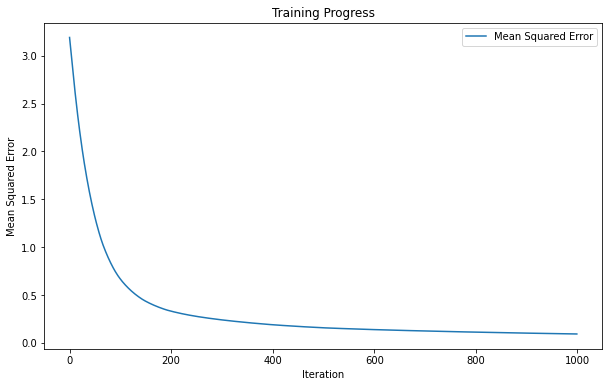

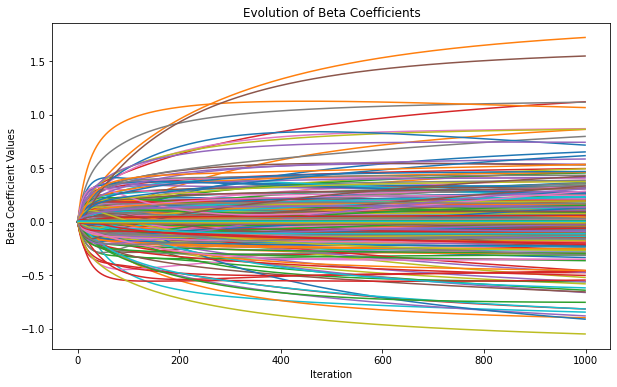

In [97]:
from matplotlib import pyplot as plt
def plot_training_progress(model):
    # Plot Mean Squared Error over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(model.itr, model.mse, label='Mean Squared Error')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Squared Error')
    plt.title('Training Progress')
    plt.legend()
    plt.show()

    # Plot beta coefficients over iterations
    num_betas = len(model.betas[0]) if model.betas else 0
    if num_betas > 0:
        plt.figure(figsize=(10, 6))
        for beta_index in range(num_betas):
            beta_values = [beta[beta_index] for beta in model.betas]
            plt.plot(model.itr, beta_values, label=f'Beta {beta_index + 1}')

        plt.xlabel('Iteration')
        plt.ylabel('Beta Coefficient Values')
        plt.title('Evolution of Beta Coefficients')
        #plt.legend()
        plt.show()
plot_training_progress(modelpoly)